<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/VAR_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroupTestB%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using VAR Model based on Patient Visits Medical Laboratory Data (Group Test B)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

     |████████████████████████████████| 1.5MB 13.1MB/s 
     |████████████████████████████████| 9.5MB 52.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 13.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491620 sha256=95bd26e87a2a5caff9bc2a5931de2d3785919e30197dd93e9cfe57f4047b4b13
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 68kB/s 
     |████████████████████████████████| 901kB 33.6MB/s 
     |████████████████████████████████| 10.1MB 56.2MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 13.1MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1

In [2]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [11]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [12]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1348 non-null   object
 1   hm        1348 non-null   int64 
 2   hm_aw     1348 non-null   int64 
 3   hm_am     1348 non-null   int64 
 4   cc        1348 non-null   int64 
 5   cc_aw     1348 non-null   int64 
 6   cc_am     1348 non-null   int64 
 7   day_week  1348 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 84.4+ KB


In [14]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data['weekday']= data.apply(lambda row: row['date'].weekday(),axis=1)
data['weekday'] = (data["weekday"] < 5).astype(int)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1348 non-null   datetime64[ns]
 1   hm        1348 non-null   int64         
 2   hm_aw     1348 non-null   int64         
 3   hm_am     1348 non-null   int64         
 4   cc        1348 non-null   int64         
 5   cc_aw     1348 non-null   int64         
 6   cc_am     1348 non-null   int64         
 7   day_week  1348 non-null   int64         
 8   weekday   1348 non-null   int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 94.9 KB


In [16]:
data.head(5)

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week,weekday
0,2017-07-01,66,48,63,44,37,45,6,0
1,2017-07-02,53,53,62,72,37,43,7,0
2,2017-07-03,74,54,59,87,42,44,1,1
3,2017-07-04,87,56,57,58,49,44,2,1
4,2017-07-05,95,62,58,72,53,44,3,1


## **Step#2 Data Processing**

### **Picking Variable**

In [17]:
df = data.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

In [18]:
cc = df['cc'].fillna(df['cc'].mean())
cc_aw = df['cc_aw'].fillna(df['cc'].mean())
cc_am = df['cc_am'].fillna(df['cc'].mean())
weekday = df['weekday'].fillna(df['cc'].mean())

In [19]:
df_cc = pd.DataFrame({'cc':cc, 'cc_aw':cc_aw, 'cc_am':cc_am, 'weekday':weekday})
df.to_csv("cc.csv")
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cc       1348 non-null   int64
 1   cc_aw    1348 non-null   int64
 2   cc_am    1348 non-null   int64
 3   weekday  1348 non-null   int64
dtypes: int64(4)
memory usage: 42.2 KB


In [20]:
df_cc.head(5)

,cc,cc_aw,cc_am,weekday
0,44,37,45,0
1,72,37,43,0
2,87,42,44,1
3,58,49,44,1
4,72,53,44,1


### **Stationary Test**

In [21]:
#creating test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):

  #Perform Dicky Fuller Test:
  print ('Result of Dicky-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                       index=['Test Statistic','p-value','#Lags Used',
                              'Number of Observations Used'])
  
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [22]:
#Loop to check all columns of the DF
import functools
df_cc.apply(functools.partial(test_stationary))

Result of Dicky-Fuller Test:
Test Statistic                  -3.0290
p-value                          0.0323
#Lags Used                      20.0000
Number of Observations Used   1327.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.7540
p-value                          0.0651
#Lags Used                      21.0000
Number of Observations Used   1326.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                  -2.9507
p-value                          0.0398
#Lags Used                      22.0000
Number of Observations Used   1325.0000
Critical Value (1%)             -3.4353
Critical Value (5%)             -2.8637
Critical Value (10%)            -2.5679
dtype: float64
Result of Dicky-Fuller Test:

cc         None
cc_aw      None
cc_am      None
weekday    None
dtype: object

### **Differencing**

In [23]:
df_diff = df_cc.diff().dropna()
df_diff = df_diff.astype(int)
df_diff.head()

,cc,cc_aw,cc_am,weekday
1,28,0,-2,0
2,15,5,1,1
3,-29,7,0,0
4,14,4,0,0
5,-13,5,0,0


In [24]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 1 to 1347
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cc       1347 non-null   int64
 1   cc_aw    1347 non-null   int64
 2   cc_am    1347 non-null   int64
 3   weekday  1347 non-null   int64
dtypes: int64(4)
memory usage: 52.6 KB


### **Model Order Selection**

In [26]:
#Creating the VAR model
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(df_diff)

In [30]:
#Bestmodel order
modsel = model.select_order(15)
modsel.summary()

,AIC,BIC,FPE,HQIC
0,4.871,4.886,130.4,4.876
1,4.237,4.315,69.19,4.266
2,3.282,3.423,26.63,3.335
3,3.095,3.298,22.09,3.171
4,2.496,2.761,12.14,2.596
5,1.538,1.865,4.655,1.661
6,-60.61,-60.22,4.743e-27,-60.47
7,-67.39*,-66.94*,5.396e-30*,-67.22*
8,-65.28,-64.76,4.461e-29,-65.09
9,-65.75,-65.17,2.798e-29,-65.53


### **Splitting Data**

In [31]:
#creating the train and validation set
train = df_diff[:int(0.8*(len(df_diff)))]
test = df_diff[int(0.8*(len(df_diff))):]

In [32]:
train.shape

(1077, 4)

In [33]:
test.shape

(270, 4)

## **Step#3 Fitting and Training Model**

In [35]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(7)

## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

In [36]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(test))

In [37]:
prediction.shape

(270, 4)

In [38]:
pd.DataFrame(prediction).head()

,0,1,2,3
0,21.4318,-0.5696,-0.5889,-1.0000
1,0.1991,-0.5860,0.2988,0.0000
2,5.5522,-1.6768,0.7015,1.0000
3,-5.7383,2.0001,0.3035,-0.0000
4,-3.4517,0.1807,-0.0005,0.0000


In [39]:
df2 = pd.DataFrame(prediction)[0]
df2.head(30)

0     21.4318
1      0.1991
2      5.5522
3     -5.7383
4     -3.4517
5     -6.5376
6    -10.3655
7     20.8027
8      0.3248
9      3.9760
10    -6.2930
11    -1.7919
12    -7.1264
13   -11.0946
14    22.2387
15    -0.6559
16     5.3619
17    -7.0382
18    -2.0784
19    -6.6212
20   -11.2728
21    22.1896
22    -0.6779
23     5.4136
24    -7.1886
25    -1.9268
26    -6.6558
27   -11.3971
28    22.3966
29    -0.7885
Name: 0, dtype: float64

In [40]:
df.head(1077)

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week,weekday
0,2017-07-01,66,48,63,44,37,45,6,0
1,2017-07-02,53,53,62,72,37,43,7,0
2,2017-07-03,74,54,59,87,42,44,1,1
3,2017-07-04,87,56,57,58,49,44,2,1
4,2017-07-05,95,62,58,72,53,44,3,1
...,...,...,...,...,...,...,...,...,...
1072,2020-06-07,39,56,47,57,46,39,7,0
1073,2020-06-08,65,54,48,36,47,40,1,1
1074,2020-06-09,62,58,48,43,45,40,2,1
1075,2020-06-10,48,57,49,44,44,40,3,1


In [48]:
#Convert to original data, 42 from the last train data (cc) values
df_diff_pred = np.cumsum(df2) + 42
pred = pd.DataFrame(df_diff_pred.astype(int))
pred = pred.rename(columns={0:'pred'})
pred.head(30)

,pred
0,63
1,63
2,69
3,63
4,59
5,53
6,43
7,63
8,64
9,68


In [49]:
#Take an original data
actual = np.cumsum(test.cc) + 42
actual = pd.DataFrame(actual)
actual['pred'] = pred['pred'].values
actual.head(30)

,cc,pred
1078,70,63
1079,67,63
1080,63,69
1081,80,63
1082,52,59
1083,54,53
1084,54,43
1085,65,63
1086,57,64
1087,86,68


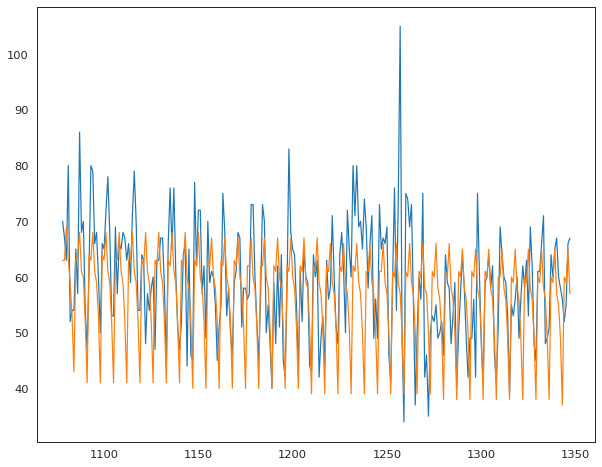

In [50]:
plt.plot(actual['cc'], label='actual')
plt.plot(actual['pred'], label='forecast')

In [51]:
# MSE and RMSE Score
print('MSE value :', mean_squared_error(actual['cc'], actual['pred']))
print('RMSE value  : ', sqrt(mean_squared_error(actual['cc'], actual['pred'])))

MSE value : 87.52222222222223
RMSE value  :  9.355331219268628
